In [1]:
%%capture

!pip install transformers diffusers accelerate -U
!pip install parediffusers

In [2]:
import torch
from parediffusers import PareDiffusionPipeline

pipe = PareDiffusionPipeline.from_pretrained(
	"stabilityai/stable-diffusion-2",
	device=torch.device("cuda"),
	dtype=torch.float16,
)

/usr/local/lib/python3.9/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/909 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [3]:
prompt = "painting depicting the sea, sunrise, ship, artstation, 4k, concept art"
num_inference_steps = 50
guidance_scale = 7.5
torch.manual_seed(2683)
width, height = 512, 512

prompt_embeds = pipe.encode_prompt(prompt)
init_latents = pipe.get_latent(width, height).unsqueeze(dim=0)

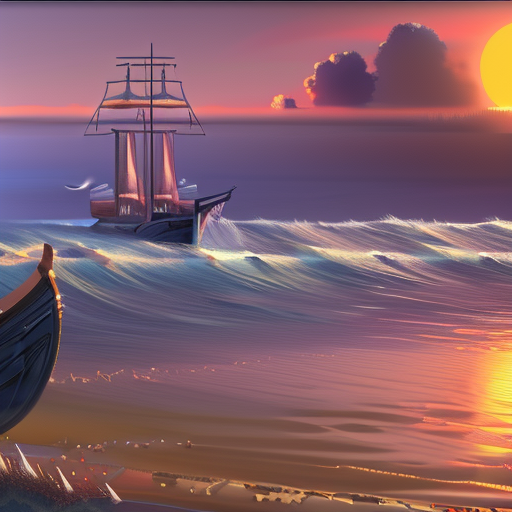

In [4]:
latents = init_latents.detach().clone()

@torch.no_grad()
def denoise(
	pipe, latents, prompt_embeds, num_inference_steps=50, guidance_scale=7.5
):
	timesteps, num_inference_steps = pipe.retrieve_timesteps(num_inference_steps)

	for t in timesteps:
		latent_model_input = torch.cat([latents] * 2)

		# Predict the noise residual for the current timestep
		noise_residual = pipe.unet(
			latent_model_input, t, encoder_hidden_states=prompt_embeds
		)
		uncond_residual, text_cond_residual = noise_residual.chunk(2)
		guided_noise_residual = uncond_residual + guidance_scale * (
			text_cond_residual - uncond_residual
		)

		# Update latents by reversing the diffusion process for the current timestep
		latents = pipe.scheduler.step(guided_noise_residual, t, latents)[0]

	return latents

latents = denoise(pipe, latents, prompt_embeds, num_inference_steps, guidance_scale)
image = pipe.vae_decode(latents)
image

/tmp/ipykernel_32/1826561155.py:12: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  t = torch.tensor((1000/num_inference_steps)*(num_inference_steps-i-1)+1, device=pipe.device, dtype=torch.long)


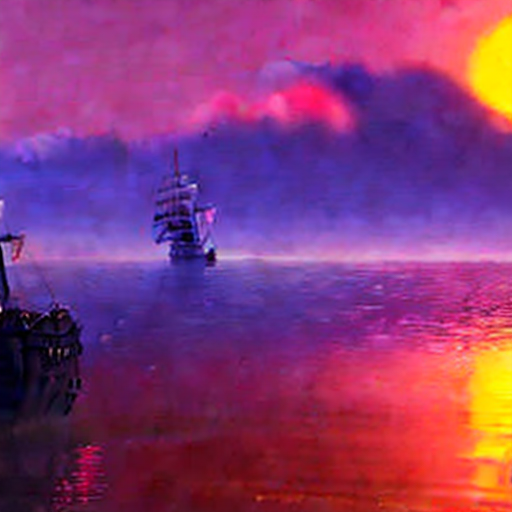

In [5]:
latents = init_latents.detach().clone()

# Denoise loop without scheduler
@torch.no_grad()
def custom_denoise(
	pipe, latents, prompt_embeds, num_inference_steps, guidance_scale, ratio
):
	for i in range(num_inference_steps):
		latent_model_input = torch.cat([latents] * 2)
		
		# Predict the noise residual for the current timestep
		t = torch.tensor((1000/num_inference_steps)*(num_inference_steps-i-1)+1, device=pipe.device, dtype=torch.long)
		noise_residual = pipe.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds)
		uncond_residual, text_cond_residual = noise_residual.chunk(2)
		guided_noise_residual = uncond_residual + guidance_scale * (text_cond_residual - uncond_residual)

		# Update the latents with the predicted noise residual
		latents = latents - (ratio * guided_noise_residual / num_inference_steps)

		#display(pipe.vae_decode(latents))
	return latents

ratio = 1.475
latents = custom_denoise(pipe, latents, prompt_embeds, num_inference_steps, guidance_scale, ratio)
image = pipe.vae_decode(latents)
image

In [6]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image as IPythonImage
from diffusers.utils.export_utils import export_to_gif

# Prepare for saving as .gif
def make_gif_with_index(texts, images, file_path, figsize=(1.28, 1.30)):
	for i, image in enumerate(images):
		fig, ax = plt.subplots(figsize=figsize)
		ax.imshow(image)
		ax.text(0.5, -0.2, f"{texts[i]:02.4f}", transform=ax.transAxes, ha="center")
		ax.axis('off')
		plt.subplots_adjust(bottom=0.2)
		plt.savefig(f"temp_{i}.png")
		plt.close(fig)

	# Read temporary images and append to the list
	images_with_index = []
	for i in range(len(images)):
		images_with_index.append(Image.open(f"temp_{i}.png"))

	# Save as .gif
	export_to_gif(images_with_index, file_path, fps=10)

	# Remove temporary image files
	for i in range(len(images)):
		os.remove(f"temp_{i}.png")

In [7]:
labels = []
images = []
for i in range(400):
	latents = init_latents.detach().clone()
	ratio = 0.5 + i/200
	labels.append(ratio)
	latents = custom_denoise(pipe, latents, prompt_embeds, num_inference_steps, guidance_scale, ratio)
	image = pipe.vae_decode(latents)
	images.append(image)

make_gif_with_index(labels, images, "outputs/custom_denoise_different_ratio.gif", figsize=(1.28*2, 1.30*2))

/tmp/ipykernel_32/1826561155.py:12: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  t = torch.tensor((1000/num_inference_steps)*(num_inference_steps-i-1)+1, device=pipe.device, dtype=torch.long)


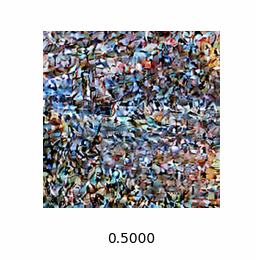

In [8]:
with open('outputs/custom_denoise_different_ratio.gif','rb') as f:
    display(IPythonImage(data=f.read(), format='png'))